# CAA PROJECT 1

## STROKE PREDICTION DATASET

Imported libraries

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from keras import datasets, layers, models
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
#from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import EarlyStopping
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from keras.regularizers import L1L2

### Data preprocessing and visualization

In [66]:
#load the data
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Drop 'id' column

In [67]:
data.drop(columns='id', inplace=True)

Search for NaN's for each feature.

In [68]:
nan_values = data.isna().sum()
print(nan_values)

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


For the 'bmi' feature there are 201 observations that are NaN's and so we removed these rows.

In [69]:
data.dropna(how='any', inplace=True)
print(len(data))

4909


Remove duplicates if there are any

In [70]:
data.drop_duplicates(inplace=True)
print(len(data))

4909


### Data visualization

Visualize the distribution of smoking status among individuals who had a stroke

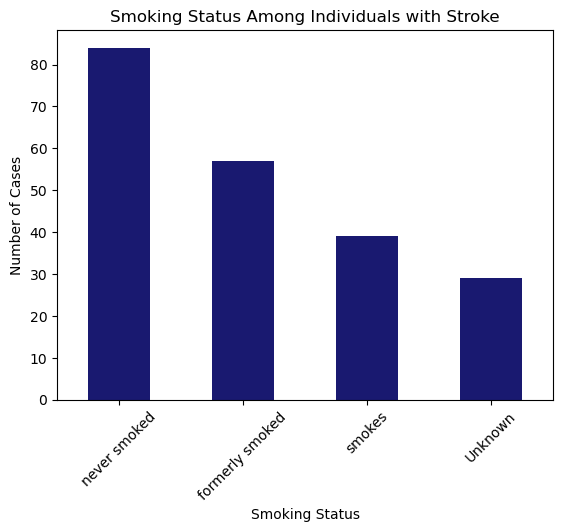

In [71]:
stroke_cases = data[data['stroke'] == 1]
smoking_counts = stroke_cases['smoking_status'].value_counts()

smoking_counts.plot(kind='bar', color='midnightblue')
plt.title('Smoking Status Among Individuals with Stroke')
plt.xlabel('Smoking Status')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.show()

Visualize the distribution of marriage status among individuals who had a stroke

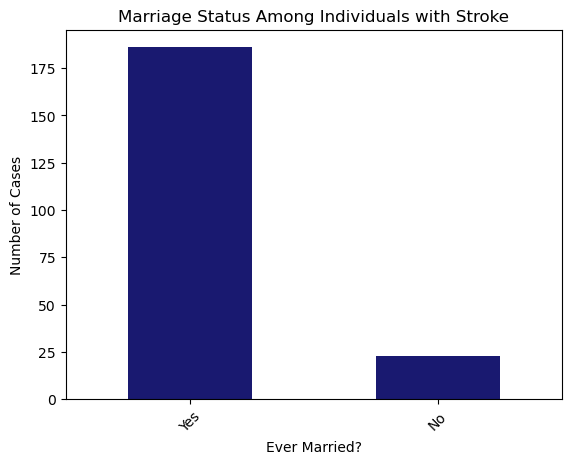

In [72]:
marriage_counts = stroke_cases['ever_married'].value_counts()

marriage_counts.plot(kind='bar', color='midnightblue')
plt.title('Marriage Status Among Individuals with Stroke')
plt.xlabel('Ever Married?')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.show()

Visualize the distribution of gender among individuals who had a stroke

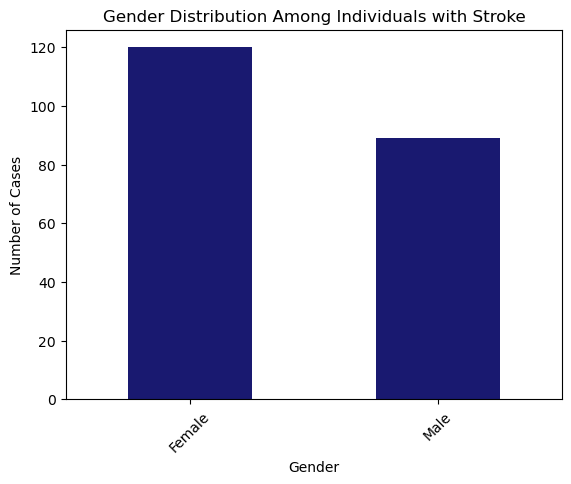

In [73]:
gender_counts = stroke_cases['gender'].value_counts()

gender_counts.plot(kind='bar', color='midnightblue')
plt.title('Gender Distribution Among Individuals with Stroke')
plt.xlabel('Gender')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.show()

Visualize the distribution of stroke cases across different intervals of BMI

In [74]:
#range of values
print(stroke_cases['bmi'].min())
print(stroke_cases['bmi'].max())

16.9
56.6


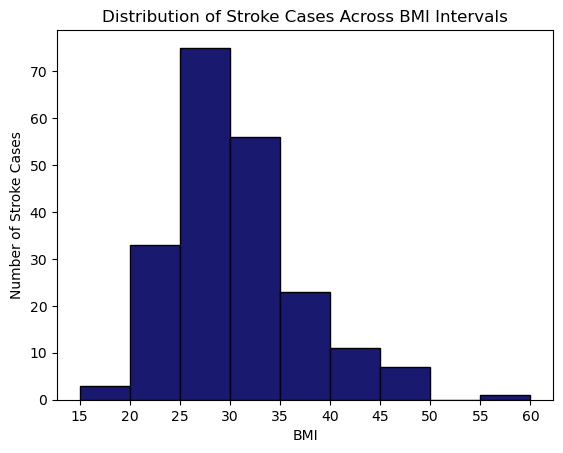

In [75]:
bmi_intervals = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

plt.hist(stroke_cases['bmi'], bins=bmi_intervals, color='midnightblue', edgecolor='black')
plt.title('Distribution of Stroke Cases Across BMI Intervals')
plt.xlabel('BMI')
plt.ylabel('Number of Stroke Cases')
plt.xticks(bmi_intervals)
plt.show()

Visualize the distribution of stroke cases across different intervals of ages

In [76]:
print(stroke_cases['age'].min())
print(stroke_cases['age'].max())

14.0
82.0


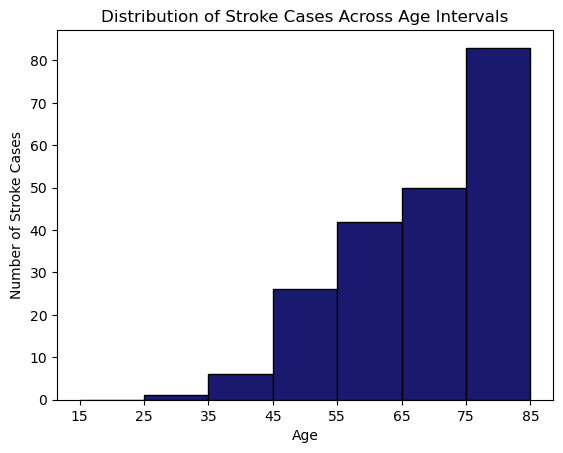

In [77]:
age_intervals = [15, 25, 35, 45, 55, 65, 75, 85]

plt.hist(stroke_cases['age'], bins=age_intervals, color='midnightblue', edgecolor='black')
plt.title('Distribution of Stroke Cases Across Age Intervals')
plt.xlabel('Age')
plt.ylabel('Number of Stroke Cases')
plt.xticks(age_intervals)
plt.show()

### Convert categorical features into numerical values

There are five features that are categorical variables (non-numerical) and therefore we applied Label Encoding to these features in order to assign a unique integer to each category.

In [78]:
for col in data.columns:
    if data[col].dtype == "object":
        print(col, ":", data[col].unique())

gender : ['Male' 'Female' 'Other']
ever_married : ['Yes' 'No']
work_type : ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type : ['Urban' 'Rural']
smoking_status : ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [79]:
label_encoder = LabelEncoder()
data['gender'] = label_encoder.fit_transform(data['gender'])
data['work_type'] = label_encoder.fit_transform(data['work_type'])
data['ever_married'] = label_encoder.fit_transform(data['ever_married'])
data['Residence_type'] = label_encoder.fit_transform(data['Residence_type'])
data['smoking_status'] = label_encoder.fit_transform(data['smoking_status'])

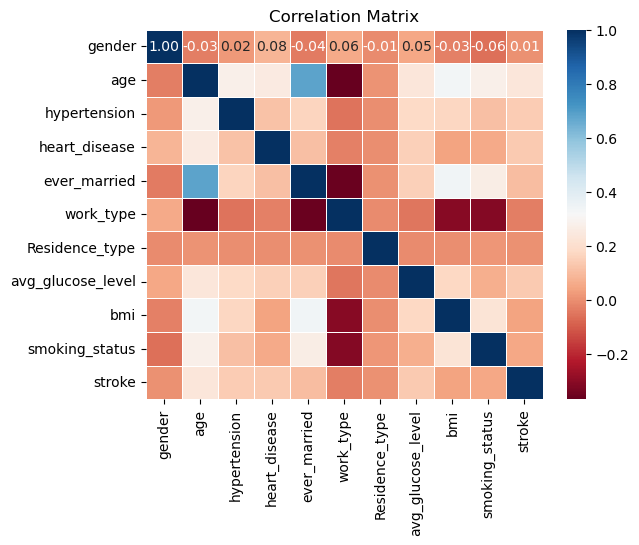

In [80]:
correlation_matrix = data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Balanced data

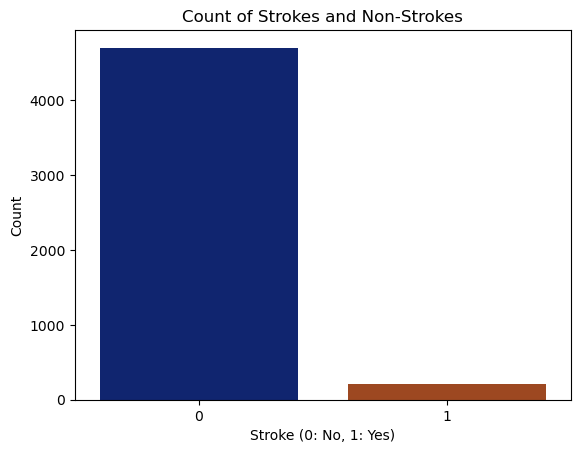

In [81]:
ax = sns.countplot(x ='stroke', data = data,  palette='dark')
plt.title('Count of Strokes and Non-Strokes')
plt.xlabel('Stroke (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

The data is highly unbalanced.

We'll use the SMOTE method in order to balance our dataset.

In [82]:
#Separate features and target variable
X = data.drop('stroke', axis=1)
y = data['stroke']

In [83]:
#Split the data into training and testing sets
X_train_split, X_test, y_train_split, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
#Split the data into training and validation sets
X_train, X_validate, y_train, y_validate = train_test_split(X_train_split, y_train_split, test_size=0.15, random_state=42)

In [84]:
#Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [85]:
print(y.value_counts())
print(y_train_res.value_counts())

stroke
0    4700
1     209
Name: count, dtype: int64
stroke
0    3396
1    3396
Name: count, dtype: int64


### Normalization

In [86]:
#function for feature normalization
def featureNormalization(x):
    mean = np.mean(x, axis = 0)
    std = np.std(x, axis = 0)

    x_norm = (x - mean)/std

    return x_norm, mean, std

In [87]:
#normalization of training data
X_train_norm, mean, std = featureNormalization(X_train_res)

In [88]:
#normalization of validation and test data
X_validate_norm = (X_validate - mean)/std
X_test_norm = (X_test - mean)/std

### FULLY CONNECTED FEEDFORWARD DNN

In [89]:
#fully connected feedforward DNN model without regularization
#trying different numbers of layers and neurons

DNN_models = []
num_of_hidden_layers = [0, 4, 9, 14]
num_of_hidden_neurons = [10, 12, 15, 20]

for n in num_of_hidden_neurons:
    for i in num_of_hidden_layers:
        model = models.Sequential()
        model.add(layers.Dense(n, activation='relu', input_shape=(X_train_norm.shape[1],)))
        for j in range(i):
            model.add(layers.Dense(n, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        
        model.compile(optimizer='Adam',
                      loss='binary_crossentropy',
                      metrics=['precision'])

        DNN_models.append(model)

C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [90]:
#train the models and cross-validate
history_all_layers = []

for model in DNN_models:
    history = model.fit(X_train_norm, y_train_res, epochs=20, batch_size=283, validation_data=(X_validate_norm, y_validate), verbose=False)
    history_all_layers.append(history)

In [91]:
print(history.history.keys())

dict_keys(['loss', 'precision', 'val_loss', 'val_precision'])


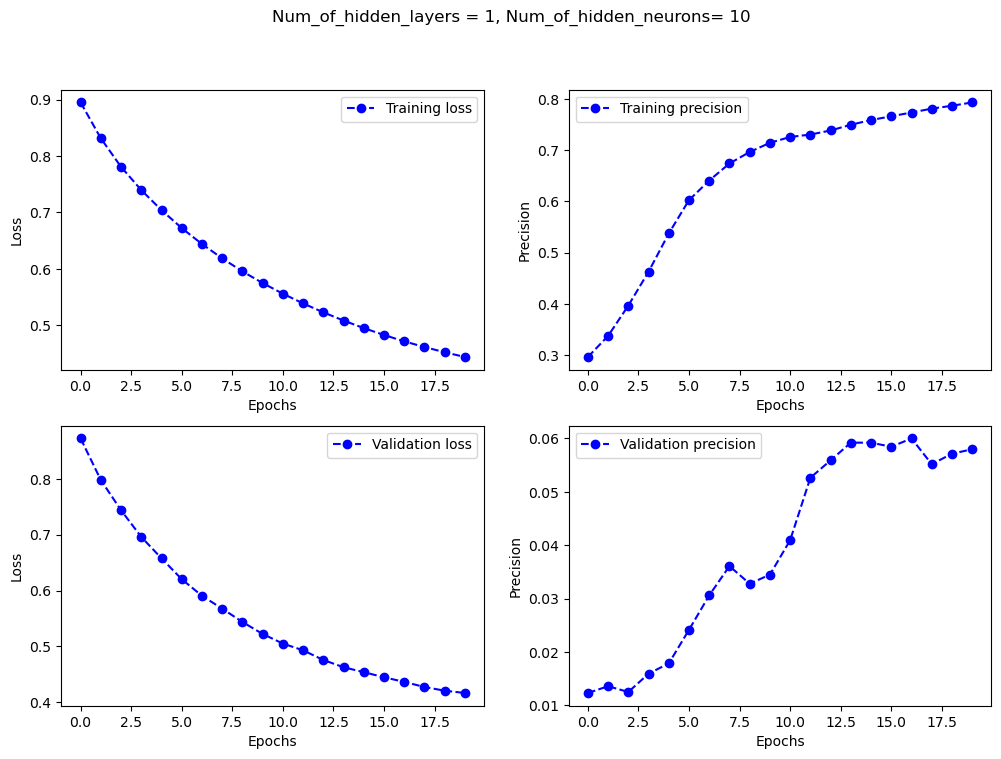

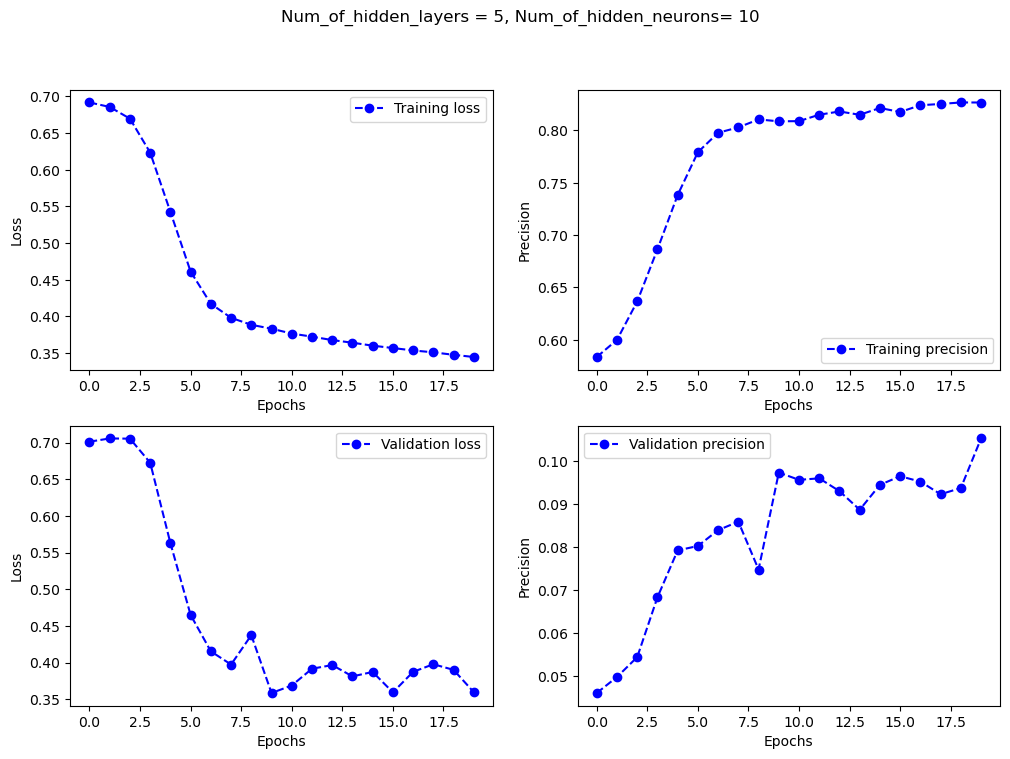

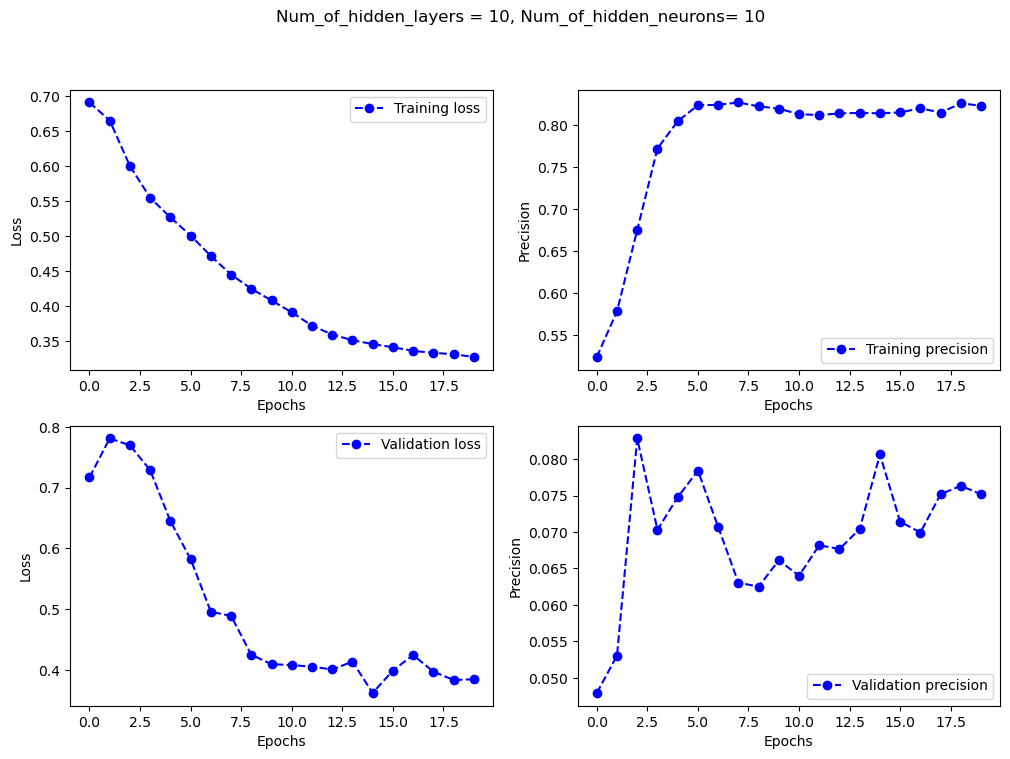

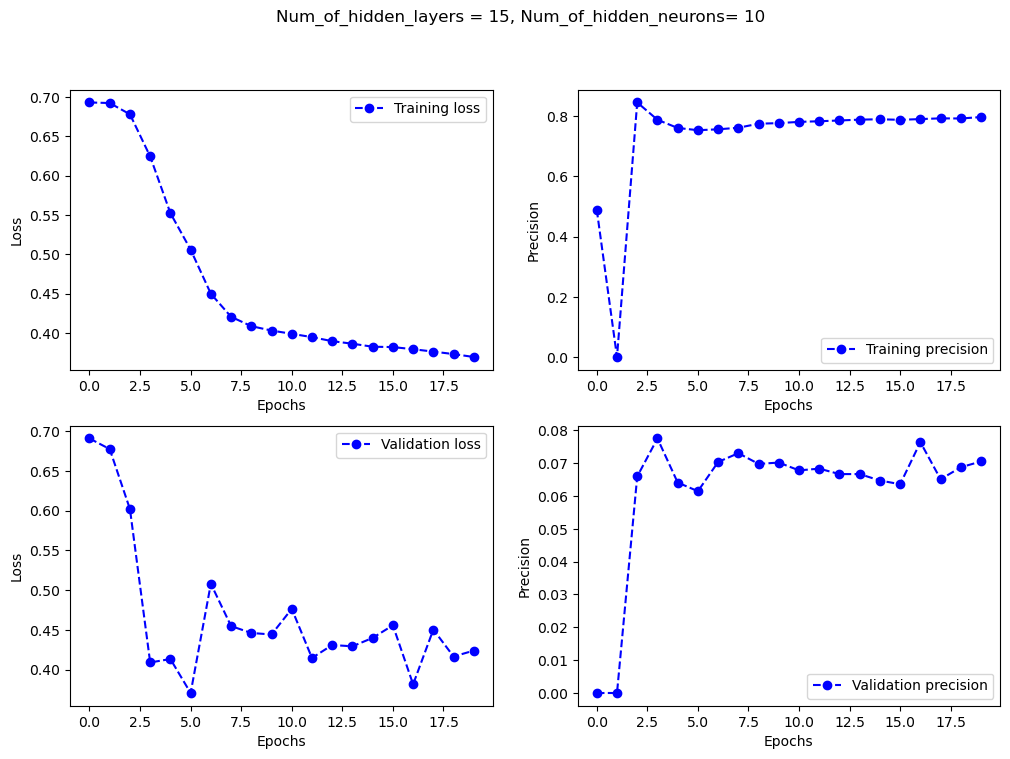

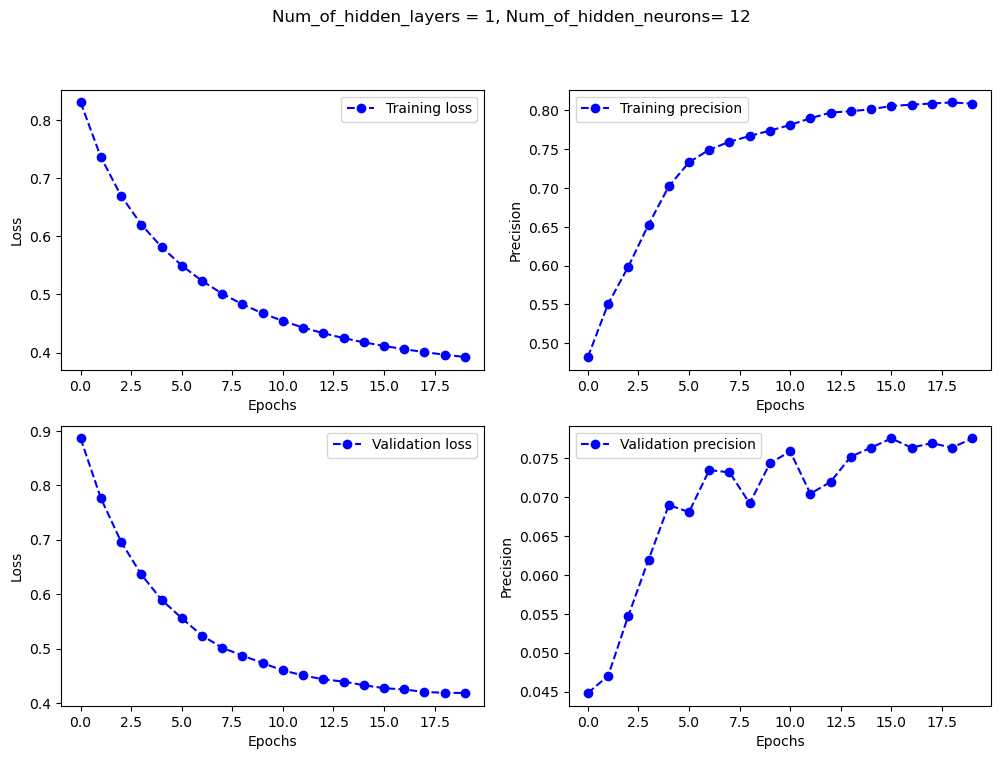

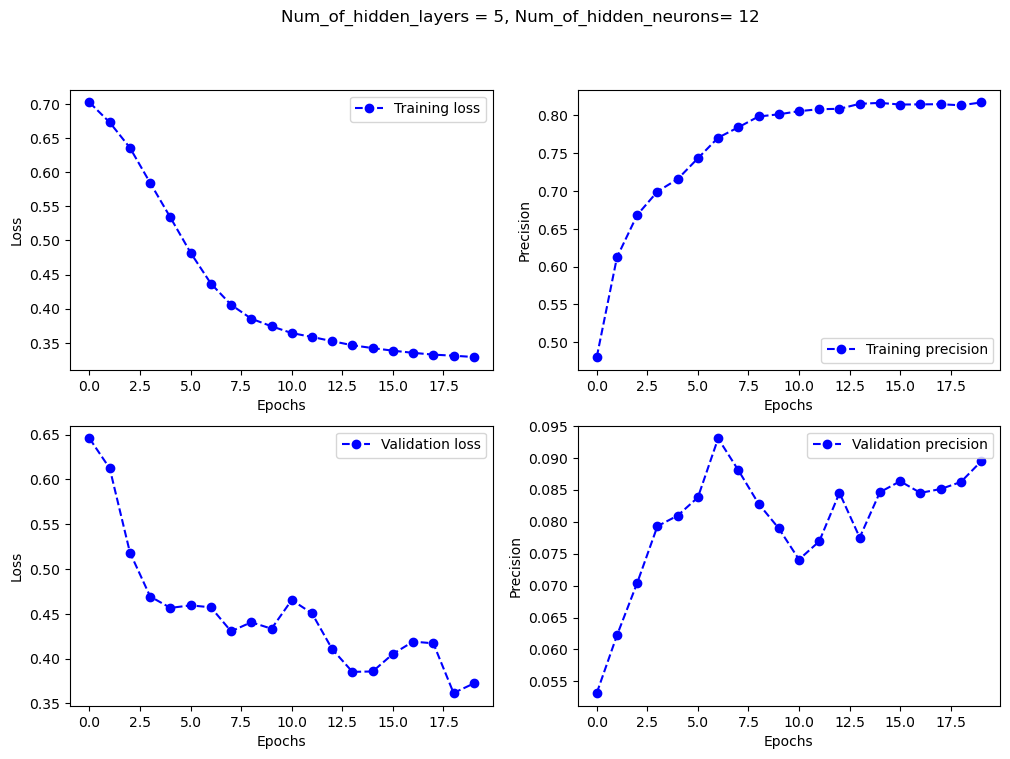

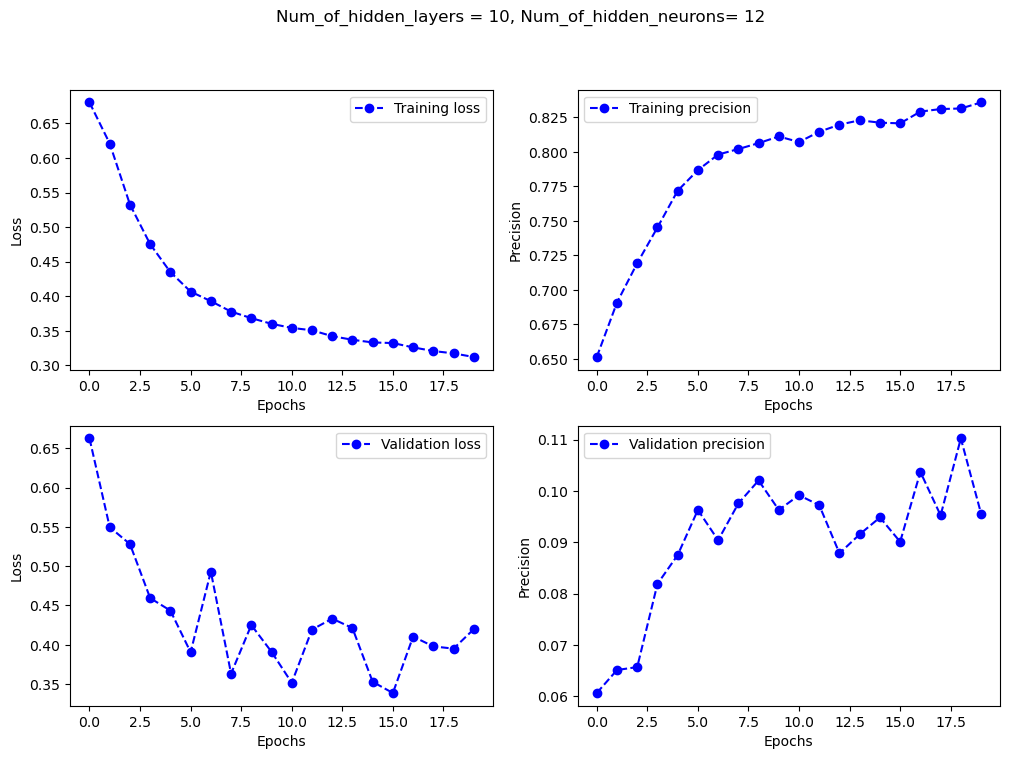

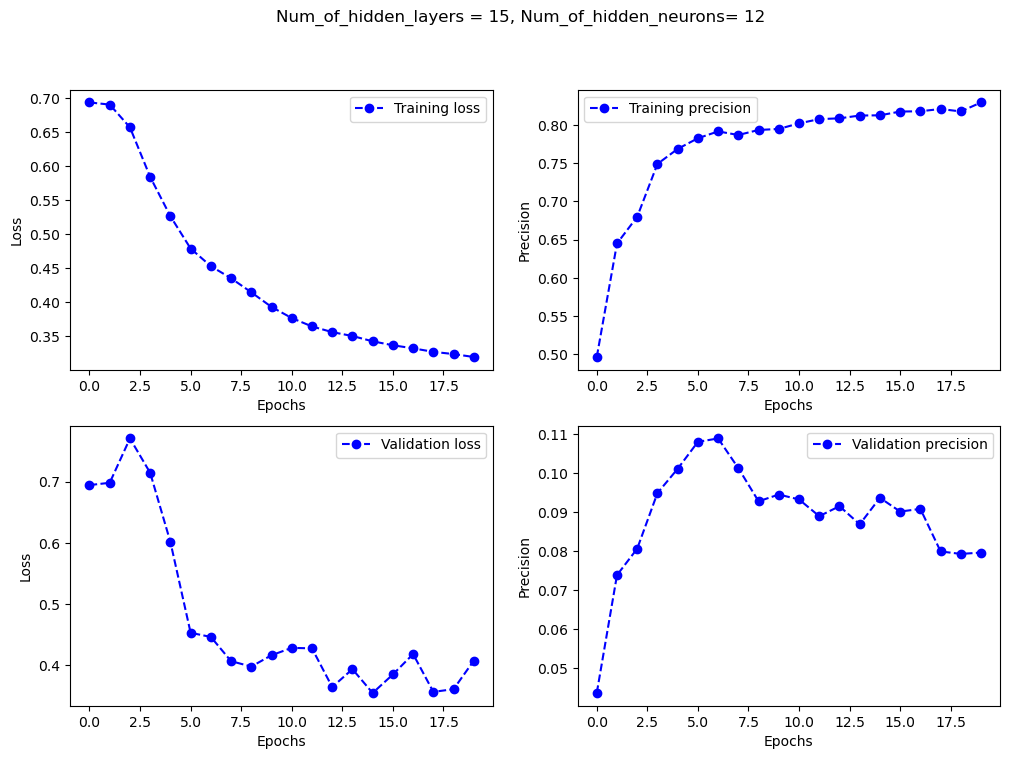

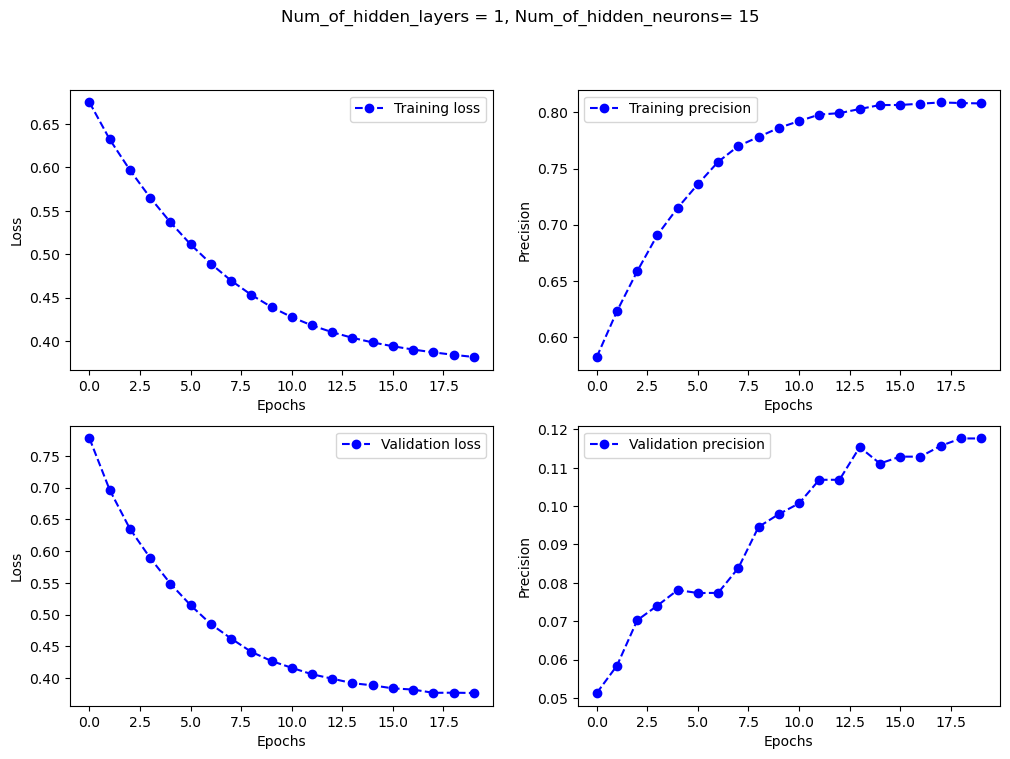

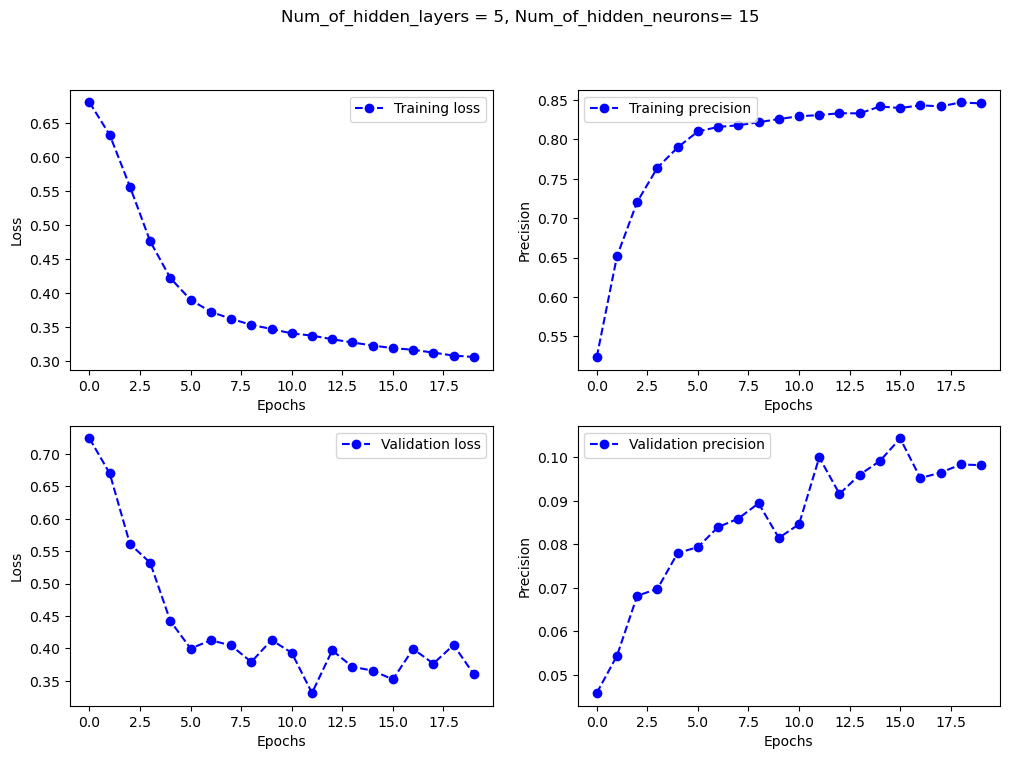

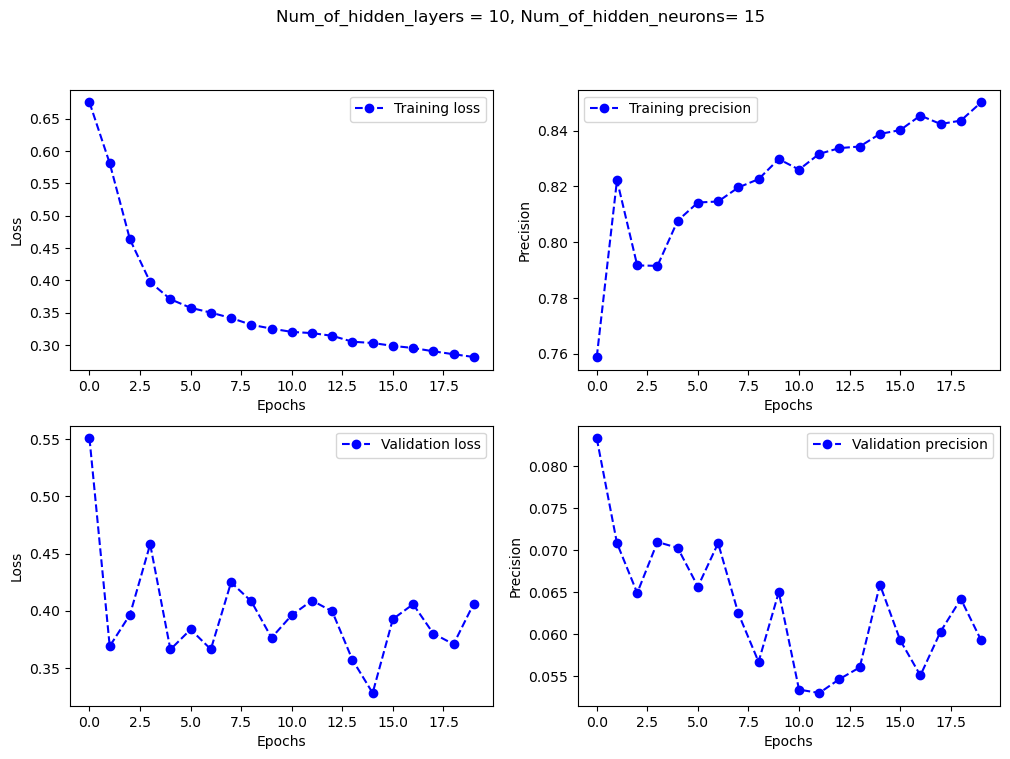

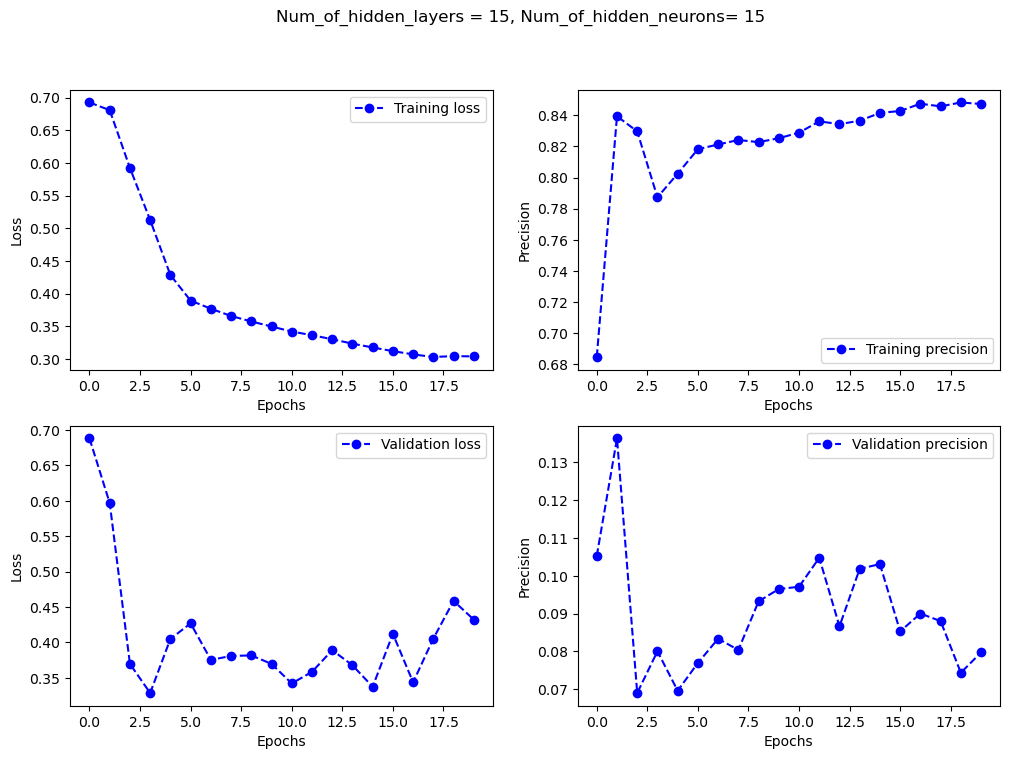

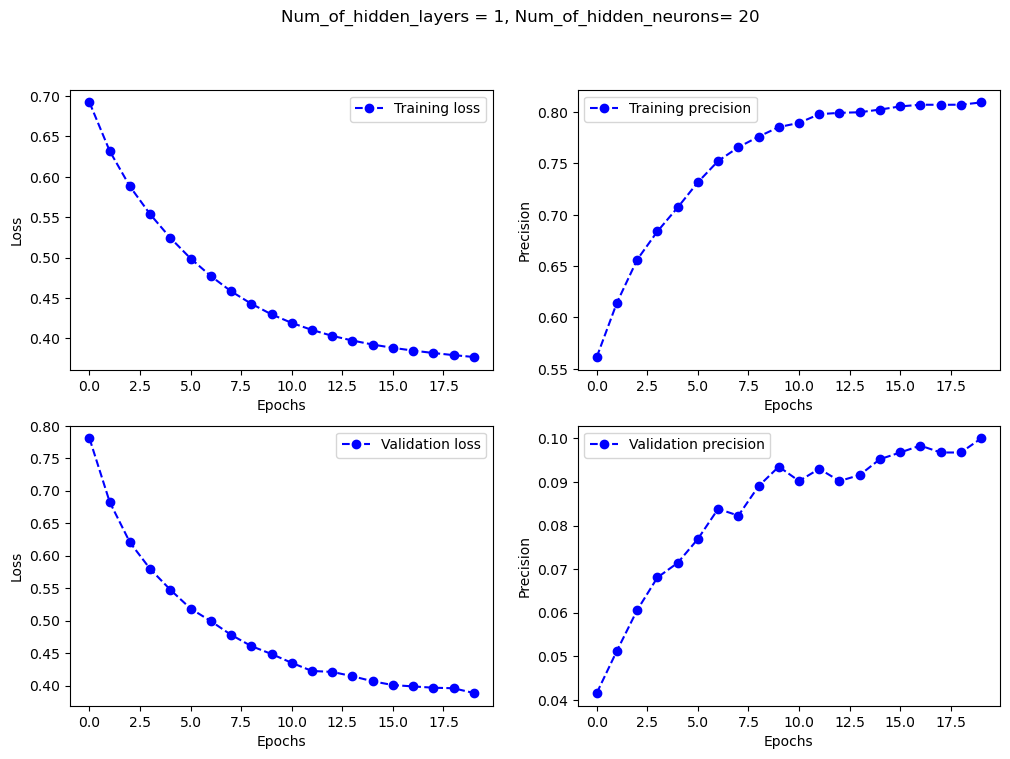

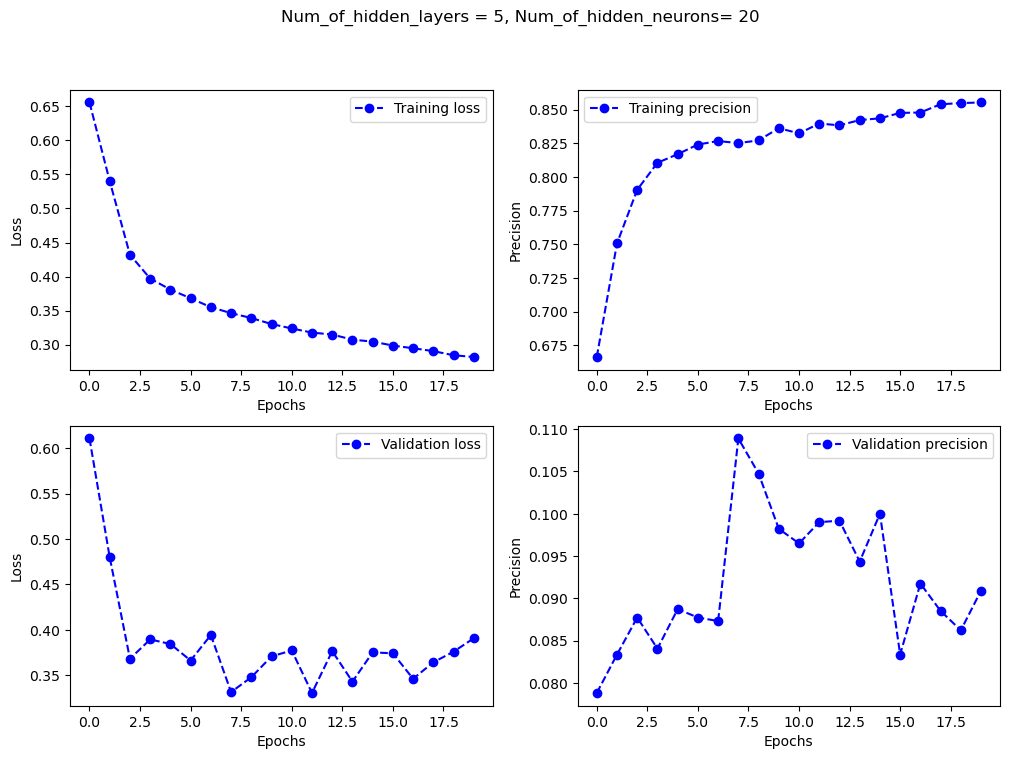

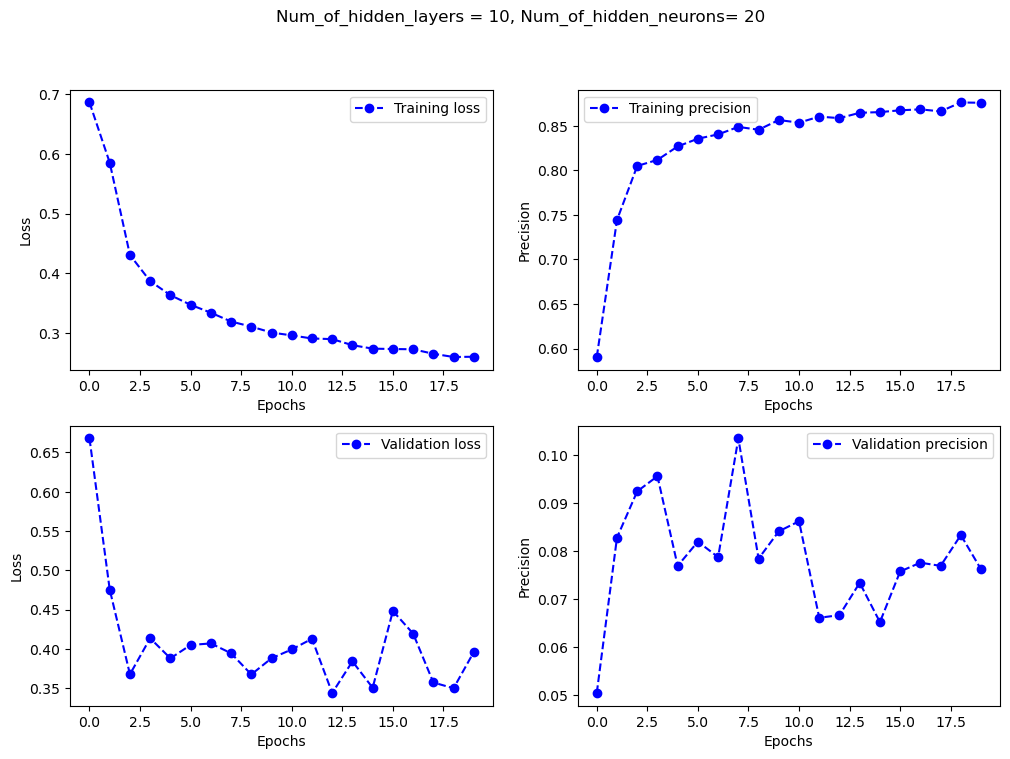

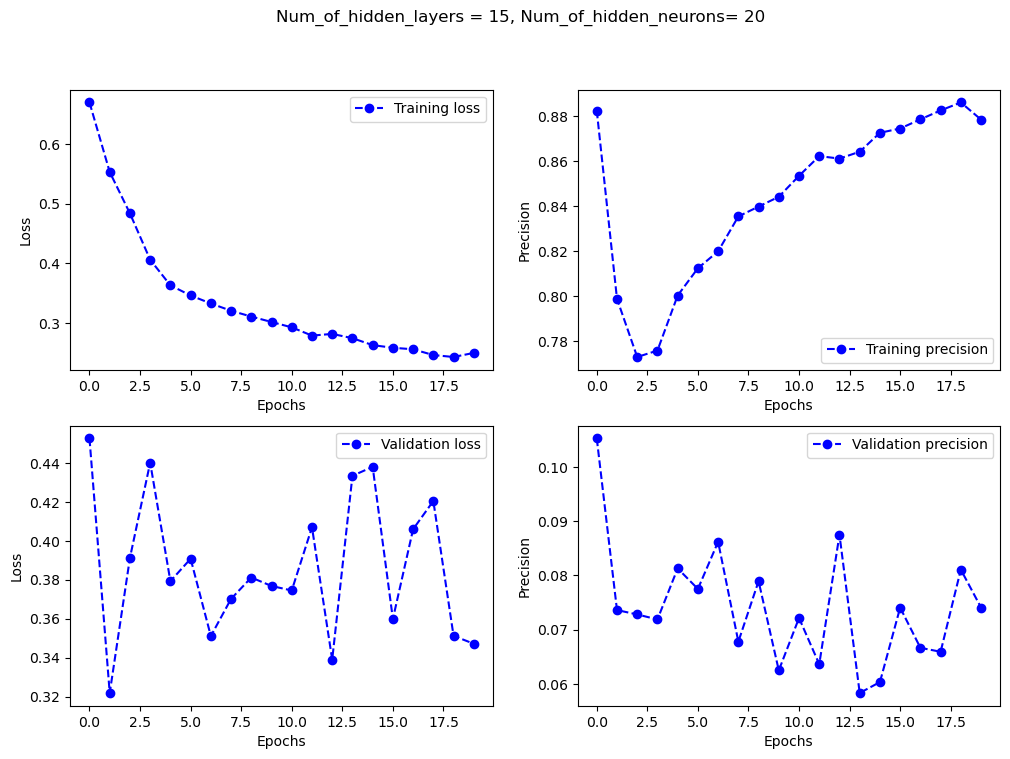

In [92]:
#ploting the metrics for training and validation data
i = 0
j = 0

for history in history_all_layers:
    
    fig, axs = plt.subplots(2,2, figsize=(12,8))
    fig.suptitle('Num_of_hidden_layers = {}, Num_of_hidden_neurons= {}'.format(num_of_hidden_layers[i]+1, num_of_hidden_neurons[j]))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], linestyle='--', marker='o', color='b', label='Training loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    plt.subplot(2, 2, 2)
    plt.plot(history.history['precision'], linestyle='--', marker='o', color='b', label='Training precision')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    
    plt.subplot(2, 2, 3)
    plt.plot(history.history['val_loss'], linestyle='--', marker='o', color='b', label='Validation loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    plt.subplot(2, 2, 4)
    plt.plot(history.history['val_precision'], linestyle='--', marker='o', color='b', label='Validation precision')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Precision")    
    
    i += 1
    if i > 3:
        i = 0
        j += 1
    

In [93]:
#find the number of layers and neurons with the highest accuracy on validation set
acc_all = []
val_loss_all = []

for history in history_all_layers:
    acc_all.append(history.history['val_precision'][-1]-history.history['val_loss'][-1])
    val_loss_all.append(history.history['val_loss'][-1])
    
max_el = max(acc_all)
best_idx = np.argmax(acc_all)
best_DNN = DNN_models[best_idx]
best_num_layers = len(best_DNN.layers)-1
best_num_neurons = best_DNN.layers[1].units
print("Layers: {}, Neurons per layer: {}, Loss on validation set: {}%".format(best_num_layers, best_num_neurons, round(val_loss_all[best_idx]*100,2)))

Layers: 5, Neurons per layer: 10, Loss on validation set: 35.96%


The best hyperparameters were chosen based on the precision and loss scores by subtracting loss from precision and taking the highest value.

### Regularization

In [94]:
#finding the best regularization factor alpha
alpha_all = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

models_reg_all = []

for alpha in alpha_all:
    model_reg = models.Sequential()
    model_reg.add(layers.Dense(best_num_neurons, activation='relu', input_shape=(X_train_norm.shape[1],)))
    for i in range(best_num_layers-1):
        model_reg.add(layers.Dense(best_num_neurons, activation='relu', kernel_regularizer=regularizers.l2(alpha)))
    model_reg.add(layers.Dense(1, activation='sigmoid'))

    model_reg.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=['precision'])
    
    models_reg_all.append(model_reg)

C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [95]:
#train regulazired model and cross-validate
history_all_reg = []

for model_reg in models_reg_all:
    history = model_reg.fit(X_train_norm, y_train_res, epochs=20, batch_size=283, validation_data=(X_validate_norm, y_validate), verbose=False)
    history_all_reg.append(history)

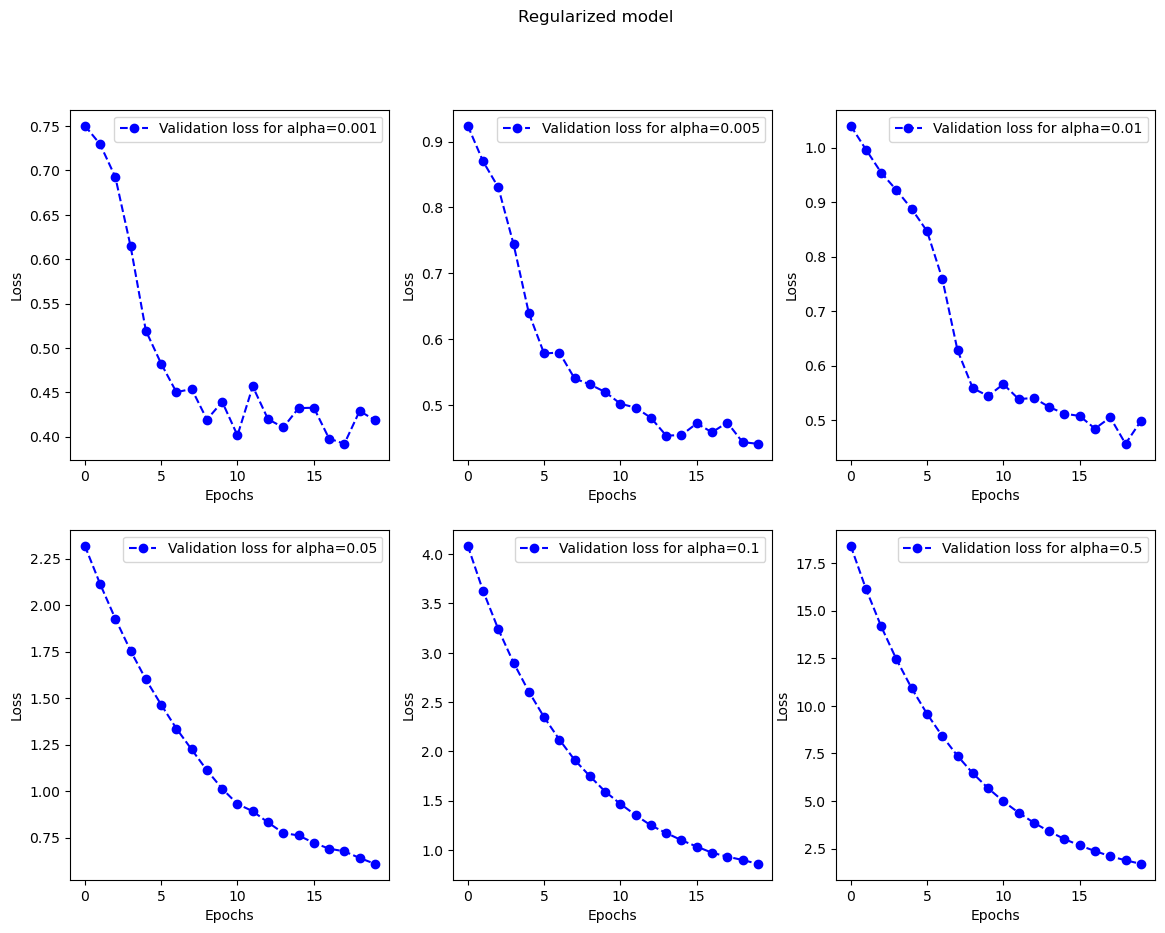

In [96]:
#plot history
fig, axs = plt.subplots(2,3, figsize=(14,10))
fig.suptitle('Regularized model')

for i, history in enumerate(history_all_reg):
    plt.subplot(2, 3, i+1)
    plt.plot(history.history['val_loss'], linestyle='--', marker='o', color='b', label='Validation loss for alpha={}'.format(alpha_all[i]))
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss") 

In [97]:
#precision and loss of the regularized model on the validation data
acc_all_reg = []
precision_all_reg = []
val_loss_all_reg = []

for history in history_all_reg:
    acc_all_reg.append(history.history['val_precision'][-1]-history.history['val_loss'][-1])
    precision_all_reg.append(history.history['val_precision'][-1])
    val_loss_all_reg.append(history.history['val_loss'][-1])

max_el_reg = max(acc_all_reg)
best_idx_reg = np.argmax(acc_all_reg)
best_alpha = alpha_all[best_idx_reg]
print("Alpha: {}, Precision on validation set: {}, Loss on validation set: {}%".format(best_alpha, round(precision_all_reg[best_idx_reg]*100,2), round(val_loss_all_reg[best_idx_reg]*100,2)))

Alpha: 0.001, Precision on validation set: 7.58, Loss on validation set: 41.87%


The best factor alpha was chosen based on the precision and loss scores by subtracting loss from precision and taking the highest value.

In [98]:
#choosing the first model that will be used on testing data
model_final_1 = models_reg_all[best_idx_reg]
print(model_final_1.summary())

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_409 (Dense)                    │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_410 (Dense)                    │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_411 (Dense)                    │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_412 (Dense)                    │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_413 (Dense)                    │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_414 (Dense)                    │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,685 (6.59 KB)

 Trainable params: 561 (2.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,124 (4.39 KB)

None


In [99]:
#evaluate model on test data
y_pred_probs = model_final_1.predict(X_test_norm, verbose=False)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

test_predictions = model_final_1.evaluate(X_test_norm, y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4625 - precision: 0.1217     


Confusion Matrix:
[[549 152]
 [ 15  21]]


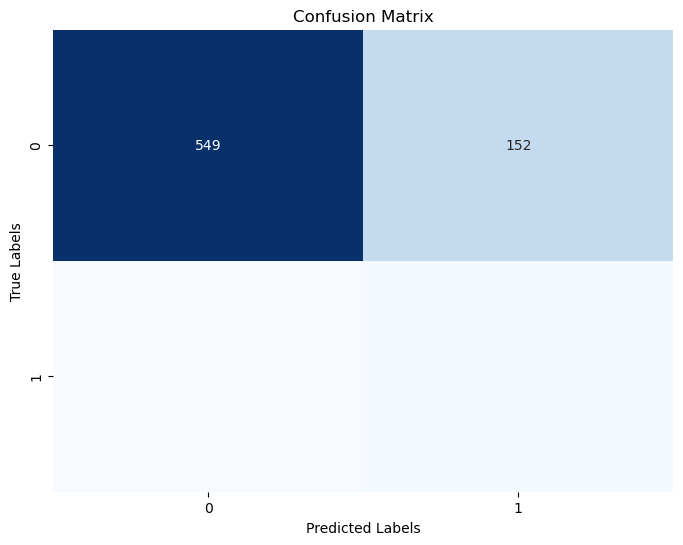

In [100]:
cm = confusion_matrix(y_test, y_pred)

#Print the confusion matrix
print("Confusion Matrix:")
print(cm)

#Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [101]:
TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[0][0]

accuracy = (TP + TN)/(TP + TN + FP + FN)
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f1_score = (2*precision*recall)/(precision+recall)

print('Accuracy: ', round(accuracy*100,2), '%')
print('Precision: ', round(precision*100,2), '%')
print('Recall: ', round(recall*100,2), '%')
print('F1 Score: ', round(f1_score*100,2), '%')

Accuracy:  77.34 %
Precision:  12.14 %
Recall:  58.33 %
F1 Score:  20.1 %


### DNN with a different number of neurons per layer

In [102]:
#fully connected feedforward DNN with a different number of neurons per layer
#dropout of 0.5 after the first layer and l1 regularization with alpha 0.01 in each layer
#early stopping after 10 sequential non-improvements of validation loss

layer_num = 5
neuron_num = [10, 4, 3, 4, 5]

model = models.Sequential()
model.add(layers.Dense(neuron_num[0], activation='relu', input_shape=(X_train_norm.shape[1],)))
model.add(layers.Dropout(0.5))
for i in neuron_num[1:]:
    model.add(layers.Dense(i, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(layers.Dense(1, activation='sigmoid'))

early = EarlyStopping(monitor='val_loss', min_delta=0, patience= 10, 
                      verbose= True, mode='auto')
callbacks = [early]

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['precision'])

C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [103]:
#train the models and cross-validate
history = model.fit(X_train_norm, y_train_res, epochs=20, batch_size=283, validation_data=(X_validate_norm, y_validate), callbacks = callbacks, verbose=False)

In [104]:
#evaluate model on test data
y_pred_probs = model.predict(X_test_norm, verbose=False)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

test_predictions = model.evaluate(X_test_norm, y_test)
print("layers: ", layer_num, "\nneurons: ", neuron_num)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7707 - precision: 0.0854 
layers:  5 
neurons:  [10, 4, 3, 4, 5]


Confusion Matrix:
[[489 212]
 [ 18  18]]


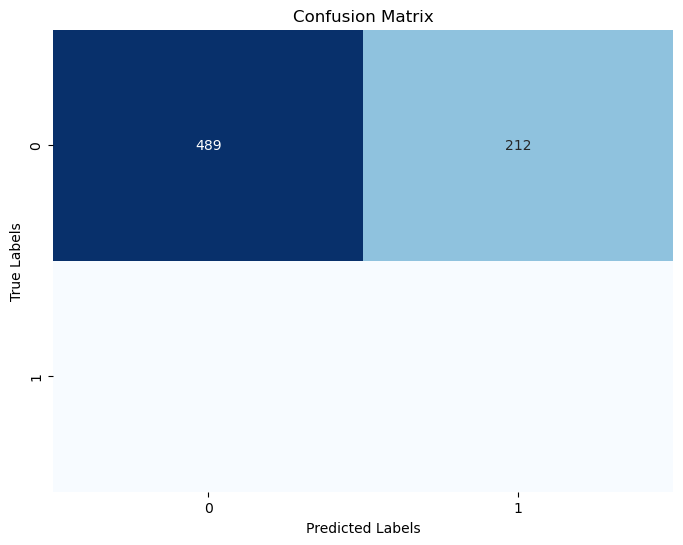

In [105]:
cm = confusion_matrix(y_test, y_pred)

#Print the confusion matrix
print("Confusion Matrix:")
print(cm)

#Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

The number of false negatives is the same, but the number of false positives is higher.

In [106]:
TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[0][0]

accuracy = (TP + TN)/(TP + TN + FP + FN)
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f1_score = (2*precision*recall)/(precision+recall)

print('Accuracy: ', round(accuracy*100,2), '%')
print('Precision: ', round(precision*100,2), '%')
print('Recall: ', round(recall*100,2), '%')
print('F1 Score: ', round(f1_score*100,2), '%')

Accuracy:  68.79 %
Precision:  7.83 %
Recall:  50.0 %
F1 Score:  13.53 %


### CATBOOSTCLASSIFIER

In [107]:
#default CatBoostClassifier
model2 = CatBoostClassifier()

# Train the model on the training data
model2.fit(X_train_norm, y_train_res, eval_set=(X_validate_norm, y_validate), verbose=False)

# Make predictions on the test data
y_predicted = model2.predict(X_test_norm)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_predicted)
print("Accuracy:", round(accuracy*100,2), "%")

Accuracy: 90.37 %


Adjusting hyperparameters to get better model performance

In [108]:
#Defining the parameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5, 0.8],
    'depth': [4, 6, 8],
    'n_estimators': [50, 100, 200],
}

### Choosing the best hyperparameters

In [109]:
#Initializing CatBoostClassifier
model2_best = CatBoostClassifier(random_seed=42, early_stopping_rounds=10, verbose=False)

#Initializing GridSearchCV
grid_search = GridSearchCV(estimator=model2_best, param_grid=param_grid, cv=3, scoring='f1', verbose=False)

#Performing grid search on the training data
grid_search.fit(X_train_norm, y_train_res)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000018BEC8BEB90>,
             param_grid={'depth': [4, 6, 8],
                         'learning_rate': [0.01, 0.1, 0.5, 0.8],
                         'n_estimators': [50, 100, 200]},
             scoring='f1', verbose=False)

In [110]:
#The best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

#Get the best model from grid search
best_model = grid_search.best_estimator_

Best Hyperparameters: {'depth': 6, 'learning_rate': 0.5, 'n_estimators': 200}


In [111]:
#Evaluate the best model on the test set
y_pred = best_model.predict(X_test_norm)
test_accuracy = best_model.score(X_test_norm, y_test)
print("Test Accuracy:", round(test_accuracy*100,2), "%")

Test Accuracy: 91.86 %


Confusion Matrix:
[[675  26]
 [ 34   2]]


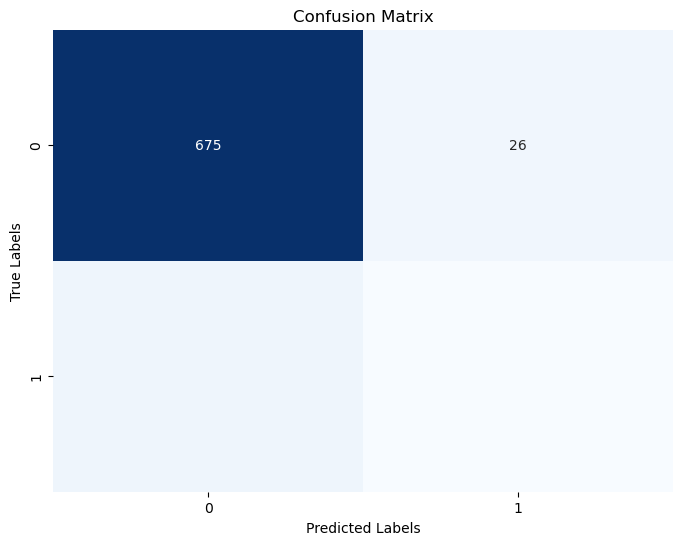

In [112]:
#Building the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Print the confusion matrix
print("Confusion Matrix:")
print(cm)

#Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


The amount of false negatives is concerning. The model predicts well if the examples are negative, but it doesn't do too well on positives.

In [113]:
TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[0][0]

accuracy = (TP + TN)/(TP + TN + FP + FN)
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f1_score = (2*precision*recall)/(precision+recall)

print('Accuracy: ', round(accuracy*100,2), '%')
print('Precision: ', round(precision*100,2), '%')
print('Recall: ', round(recall*100,2), '%')
print('F1 Score: ', round(f1_score*100,2), '%')

Accuracy:  91.86 %
Precision:  7.14 %
Recall:  5.56 %
F1 Score:  6.25 %


### 1D CONVOLUTIONAL NEURAL NETWORK

The 1D CNN model will consist of 2 convolutional layers and two dense layers. A hyperparameter search was performed in order to find the best number of filters  and kernel size for the convolutional layers and the best dropout rate.

In [114]:
# Define the model
def create_model(filters, kernel_size, dropout_rate):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train_norm.shape[1], 1), kernel_regularizer=regularizers.l1(0.005)))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# Define the hyperparameter search space
filters = [16, 32, 64]
kernel_size = [3, 5]
dropout_rate = [0.2, 0.4, 0.5]

input_shape = (X_train_norm.shape[1], 1)

best_accuracy = 0
best_params = None

for f in filters:
    for k in kernel_size:
        for d in dropout_rate:
            model_cnn = create_model(f, k, d)
            model_cnn.fit(X_train_norm, y_train_res, epochs=20, batch_size=32, validation_data= ((X_validate_norm, y_validate)), verbose=False)
            loss, accuracy = model_cnn.evaluate(X_test_norm, y_test)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = (f, k, d)

C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7430 - loss: 0.5302


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7307 - loss: 0.5092


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7467 - loss: 0.5278 


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0539 - loss: 0.7014 


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7011 - loss: 0.5133


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9461 - loss: 0.6844 


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7489 - loss: 0.5171 


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6715 - loss: 0.5616 


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0539 - loss: 0.6969 


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7503 - loss: 0.5349 


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0539 - loss: 0.7006 


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0539 - loss: 0.7004 


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9461 - loss: 0.6967 


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9461 - loss: 0.6969 


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0539 - loss: 0.7041 


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9461 - loss: 0.7050 


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0539 - loss: 0.7096 


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0539 - loss: 0.7080 


In [115]:
print(f"Best accuracy: {best_accuracy}, Best parameters: Filters={best_params[0]}, Kernel Size={best_params[1]}, Dropout Rate={best_params[2]}")

Best accuracy: 0.9511533379554749, Best parameters: Filters=16, Kernel Size=5, Dropout Rate=0.5


In [116]:
model_cnn = create_model(best_params[0], best_params[1], best_params[2])

history_cnn = model_cnn.fit(X_train_norm, y_train_res, epochs=30, batch_size=32, validation_data= (X_validate_norm, y_validate), verbose=False)

C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [117]:
loss, accuracy = model_cnn.evaluate(X_test_norm, y_test)
print(f'Test Accuracy: {accuracy}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6928 - loss: 0.5867 
Test Accuracy: 0.6974219679832458


Text(0, 0.5, 'Accuracy')

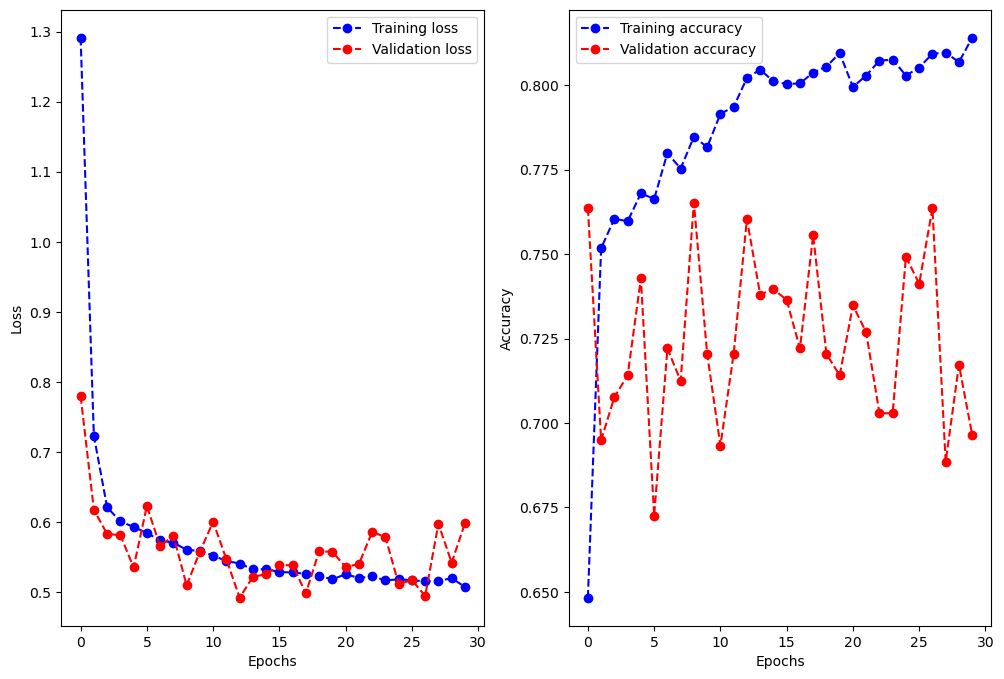

In [118]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], linestyle='--', marker='o', color='b', label='Training loss')
plt.plot(history_cnn.history['val_loss'], linestyle='--', marker='o', color='r', label='Validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
    
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], linestyle='--', marker='o', color='b', label='Training accuracy')
plt.plot(history_cnn.history['val_accuracy'], linestyle='--', marker='o', color='r', label='Validation accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [119]:
# predict values for the test set
predictions = model_cnn.predict(X_test_norm)
predictions = (predictions > 0.5).astype(int)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [120]:
# confusion matrix for 1D CNN model
cm = confusion_matrix(y_test, predictions)

TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[0][0]

In [121]:
accuracy = (TP + TN)/(TP + TN + FP + FN)
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f1_score = (2*precision*recall)/(precision+recall)

print('Accuracy: ', round(accuracy*100,2), '%')
print('Precision: ', round(precision*100,2), '%')
print('Recall: ', round(recall*100,2), '%')
print('F1 Score: ', round(f1_score*100,2), '%')

Accuracy:  69.74 %
Precision:  9.87 %
Recall:  63.89 %
F1 Score:  17.1 %


[[491 210]
 [ 13  23]]


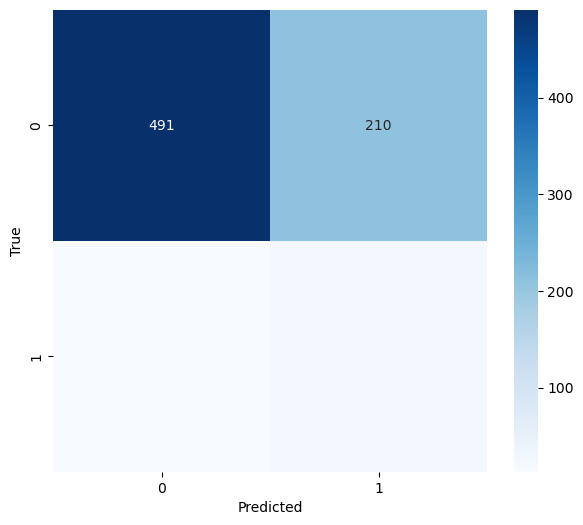

In [122]:
# Plotting the confusion matrix
print(cm)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot= True, fmt='d', cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### MultiLayer Perceptron (MLP)

In [123]:
# Define the hyperparameter space
parameter_space = {
    'hidden_layer_sizes': [(10,5), (10,10,10), (50,50,50), (50,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Initialize the MLPClassifier
mlp = MLPClassifier(max_iter=100)

# Set up GridSearchCV
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)

# Fit the model
clf.fit(X_train_norm, y_train_res)

# Best parameters found
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


C:\Users\Acer\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [124]:
# MLP classifier with best parameters found
mlp = MLPClassifier(hidden_layer_sizes=(50, 100, 50), max_iter=200, alpha=0.0001,
                    solver='adam', activation='relu', verbose=10, random_state=1,
                    learning_rate='adaptive')

mlp_history = mlp.fit(X_train_norm, y_train_res)

Iteration 1, loss = 0.50254997
Iteration 2, loss = 0.37818439
Iteration 3, loss = 0.34977833
Iteration 4, loss = 0.33248610
Iteration 5, loss = 0.32069021
Iteration 6, loss = 0.31015193
Iteration 7, loss = 0.29715948
Iteration 8, loss = 0.28955129
Iteration 9, loss = 0.28102780
Iteration 10, loss = 0.27348739
Iteration 11, loss = 0.26609395
Iteration 12, loss = 0.25952645
Iteration 13, loss = 0.25514814
Iteration 14, loss = 0.24807969
Iteration 15, loss = 0.24018283
Iteration 16, loss = 0.23413639
Iteration 17, loss = 0.22884761
Iteration 18, loss = 0.22301306
Iteration 19, loss = 0.21880999
Iteration 20, loss = 0.21220144
Iteration 21, loss = 0.20519842
Iteration 22, loss = 0.20245257
Iteration 23, loss = 0.19797280
Iteration 24, loss = 0.19367220
Iteration 25, loss = 0.19072432
Iteration 26, loss = 0.18894962
Iteration 27, loss = 0.18287222
Iteration 28, loss = 0.18186892
Iteration 29, loss = 0.17269816
Iteration 30, loss = 0.16868765
Iteration 31, loss = 0.16383573
Iteration 32, los

Text(0, 0.5, 'Loss')

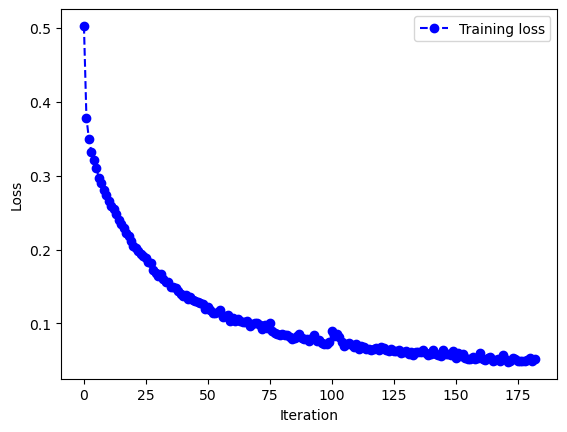

In [125]:
# plot the loss values for each iteration
plt.plot(mlp_history.loss_curve_, linestyle='--', marker='o', color='b', label='Training loss')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [126]:
# predict values for test set
y_pred = mlp.predict(X_test_norm)

In [127]:
# Confusion matrix for MLP classifier
cm = confusion_matrix(y_test, y_pred)

TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[0][0]

accuracy = (TP + TN)/(TP + TN + FP + FN)
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f1_score = (2*precision*recall)/(precision+recall)

print('Accuracy: ', round(accuracy*100,2), '%')
print('Precision: ', round(precision*100,2), '%')
print('Recall: ', round(recall*100,2), '%')
print('F1 Score: ', round(f1_score*100,2), '%')

Accuracy:  85.48 %
Precision:  8.24 %
Recall:  19.44 %
F1 Score:  11.57 %


[[623  78]
 [ 29   7]]


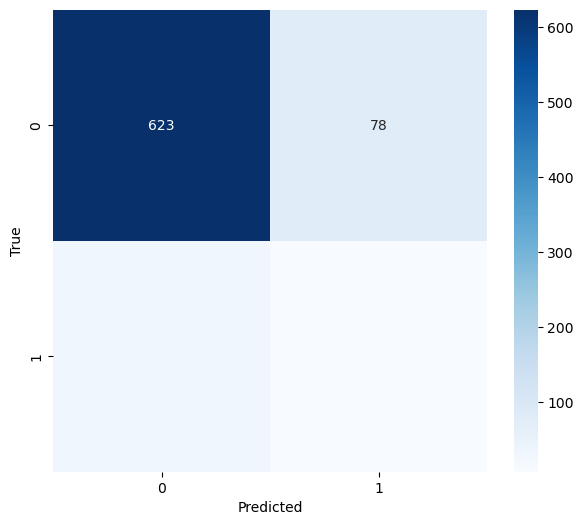

In [128]:
# Plotting the confusion matrix
print(cm)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot= True, fmt='d', cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()